<a href="https://colab.research.google.com/github/sambhav-antriksh/Fourier_Neural_Network/blob/main/simple_FNO_in_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Neural Operators (FNO) in JAX

together with [Equinox](https://docs.kidger.site/equinox/all-of-equinox/) and [Optax](https://optax.readthedocs.io/en/latest/).

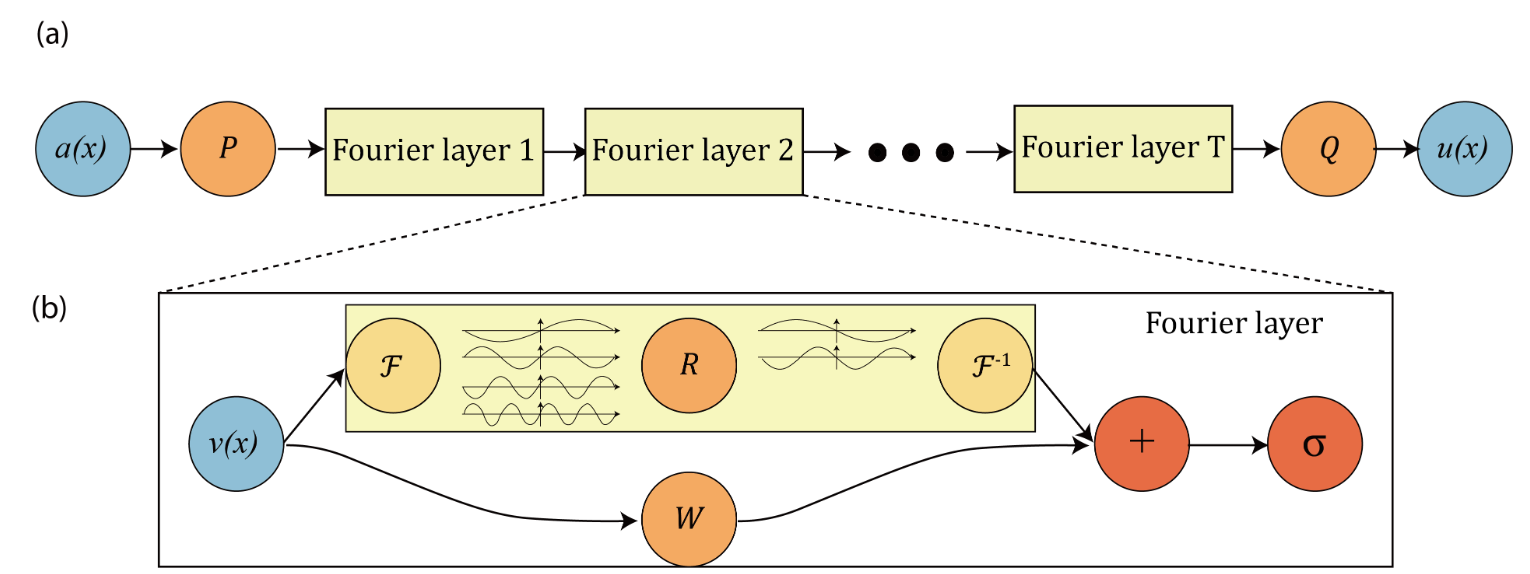

Neural Operators are mappings between discretized function spaces, for example:

* Map from an initial condition to the solution function at a later point in time (or to the entire spatiotemporal solution funciton)
* Map from the function describing an inhomogeneous diffusivity distribution to the solution of the heat equation
* Autoregressive timesteppers, map state $u^{[t]}_h$ to state $u_h^{[t+1]}$

Fouries Neural Operators do so by employing the FFT to perform efficient **spectral convolution** taking into account global features. In that sense they are a multiscale architecture (Classical convolutional architectures are only local and their receptive field depends on the depth of the network).

Neural Operators allow for the solution of a whole parametric family of PDEs!

FNOs allow for **zero-shot superresolution**.

## Spectral Convolutions

Given the (real-valued) input discretized state $a$ (with potentially more than one channel) defined on an equidistant mesh; do the following steps:

1. Transform $a$ into Fourier space (here using the real-valued Fourier transform): $\hat{a} = \text{rfft}(a)$ (batch over the channel dimension)
2. Perform a batched matrix multiplication with a complex-valued weight vector $W$ for the first $K$ modes: $\hat{\tilde{a}}_{0:K} = W\hat{a}_{0:K}$
3. Set all the leftover modes to zero $\hat{\tilde{a}}_{K:} = 0 + 0i$
4. Transform back into real space $\tilde{a} = \text{irfft}(\hat{\tilde{a}})$

The learnable parameters for each spectral convolution are the complex-valued weight matrix of shape `(channels_out, channels_in, modes)` (Since it is complex-valued it actually has `2 * channels_out * channels_in * modes` real parameters)

## Fourier Neural Operator

A classical FNO consists of a lifting layer, multiple "ResNet"-like blocks of spectral convolutions with a bypass, and a projection layer. Projection and Lifting layer are 1x1 Convolutions to only modify the channel dimensions. The blocks operate as $b = \text{activation}(\tilde{a} + \text{Conv}_{1\times1}(a))$.


Here, we will mimic one example done in the original paper by [Li et al.](https://arxiv.org/pdf/2010.08895.pdf) as implemented in their [reference code](https://github.com/neuraloperator/neuraloperator/blob/af93f781d5e013f8ba5c52baa547f2ada304ffb0/fourier_1d.py) to solve the **1d Burgers equation**

$$ \frac{\partial u}{∂ t} + \frac{1}{2}\frac{\partial u^2}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

The domain $\Omega = (0, 2 \pi)$ is periodic (i.e., $u(t, x=0) = u(t, x=2 \pi)$) and the diffusivity is fixed to $\nu=0.1$. Our dataset consists of $2048$ initial conditions $u(t=0, x)$ on a $N=8192$ resolution together with their solution at time one $u(t=1, x)$. The goal of the FNO is to learn the mapping from initial condition to state at time one using classical supervised learning. The input to the network is the input state channel-concatenated with the spatial coordinates of the meshpoints. The output is just the state at time one.

### Additional technicalities

* We train on the $32$-fold downsampled dataset (i.e., $256$ DoFs instead of $8192$)
    * Training is on the first 1000 data points
    * Validation/Testing is on the following 200 data points
* The FNO uses $16$ modes, $64$ hidden channels, and has four stacked spectral convolution blocks with bypass
* The dataset is reshuffled each epoch and the batch size is $100$
* We perform $200$ epochs in total
* Training is done with the Adam optimizer in default settings with a fixed learning rate of 3e-4

### Differences from the reference code

There are minor deviations from the [reference implementation](https://github.com/neuraloperator/neuraloperator/blob/af93f781d5e013f8ba5c52baa547f2ada304ffb0/fourier_1d.py), for example:

* Here, the dataset is preconcatenated with the mesh. The mesh is not concatenated with the input on the fly
* No activation in the projection layer. Instead the final Fourier block is activated.
* Anything I missed? I intended this script to be a pedagocial reduction, please let me know if there is an important detail I forgot.

In [ ]:
%pip install equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm

/tmp/ipython-input-3091149478.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Mathworks (the creators of Matlab) host the original Li et al. dataset in the .mat format
!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat

--2025-10-08 08:53:33--  https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
Resolving ssd.mathworks.com (ssd.mathworks.com)... 23.42.90.143
Connecting to ssd.mathworks.com (ssd.mathworks.com)|23.42.90.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644427710 (615M) [text/plain]
Saving to: ‘burgers_data_R10.mat’

burgers_data_R10.ma 100%[===================>] 614.57M  91.0MB/s    in 6.8s    

2025-10-08 08:53:41 (89.8 MB/s) - ‘burgers_data_R10.mat’ saved [644427710/644427710]



In [ ]:
data = scipy.io.loadmat("burgers_data_R10.mat")

In [ ]:
a, u = data["a"], data["u"]

In [ ]:
a.shape

(2048, 8192)

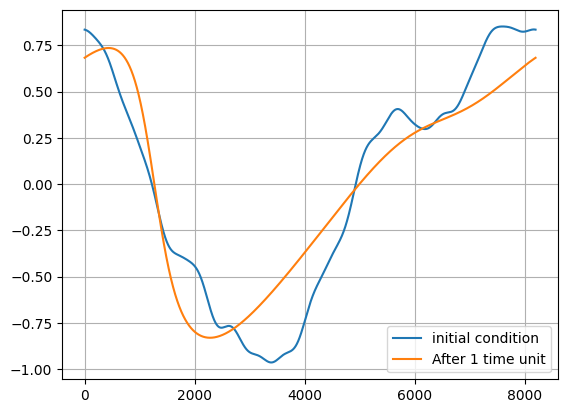

In [ ]:
plt.plot(a[0], label="initial condition")
plt.plot(u[0], label="After 1 time unit")
plt.legend()
plt.grid()

In [ ]:
# Add channel dimension
a = a[:, jnp.newaxis, :]
u = u[:, jnp.newaxis, :]

In [ ]:
# Mesh is from 0 to 2 pi
mesh = jnp.linspace(0, 2 * jnp.pi, u.shape[-1])

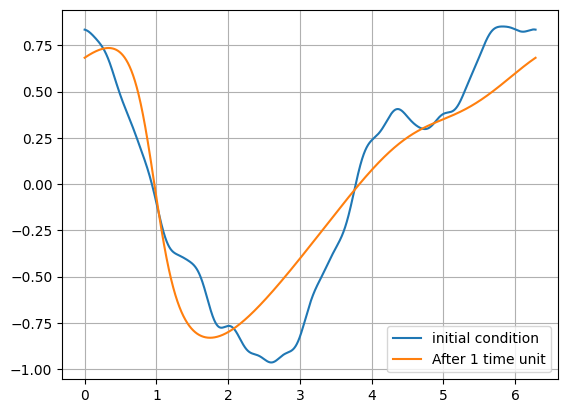

In [ ]:
plt.plot(mesh, a[0, 0], label="initial condition")
plt.plot(mesh, u[0, 0], label="After 1 time unit")
plt.legend()
plt.grid()

In [ ]:
mesh_shape_corrected = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], u.shape[0], axis=0)
a_with_mesh = jnp.concatenate((a, mesh_shape_corrected), axis=1)

In [ ]:
a_with_mesh.shape

(2048, 2, 8192)

In [ ]:
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

In [ ]:
class SpectralConv1d(eqx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            *,
            key,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        scale = 1.0 / (in_channels * out_channels)

        real_key, imag_key = jax.random.split(key)
        self.real_weights = jax.random.uniform(
            real_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )
        self.imag_weights = jax.random.uniform(
            imag_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )

    def complex_mult1d(
            self,
            x_hat,
            w,
    ):
        return jnp.einsum("iM,ioM->oM", x_hat, w)


    def __call__(
            self,
            x,
    ):
        channels, spatial_points = x.shape

        # shape of x_hat is (in_channels, spatial_points//2+1)
        x_hat = jnp.fft.rfft(x)
        # shape of x_hat_under_modes is (in_channels, self.modes)
        x_hat_under_modes = x_hat[:, :self.modes]
        weights = self.real_weights + 1j * self.imag_weights
        # shape of out_hat_under_modes is (out_channels, self.modes)
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)

        # shape of out_hat is (out_channels, spatial_points//2+1)
        out_hat = jnp.zeros(
            (self.out_channels, x_hat.shape[-1]),
            dtype=x_hat.dtype
        )
        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)

        out = jnp.fft.irfft(out_hat, n=spatial_points)

        return out


In [ ]:
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass_conv: eqx.nn.Conv1d
    activation: Callable

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            activation,
            *,
            key,
    ):
        spectral_conv_key, bypass_conv_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key,
        )
        self.bypass_conv = eqx.nn.Conv1d(
            in_channels,
            out_channels,
            1,  # Kernel size is one
            key=bypass_conv_key,
        )
        self.activation = activation

    def __call__(
            self,
            x,
    ):
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )

In [ ]:
class FNO1d(eqx.Module):
    lifting: eqx.nn.Conv1d
    fno_blocks: List[FNOBlock1d]
    projection: eqx.nn.Conv1d

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            width,
            activation,
            n_blocks = 4,
            *,
            key,
    ):
        key, lifting_key = jax.random.split(key)
        self.lifting = eqx.nn.Conv1d(
            in_channels,
            width,
            1,
            key=lifting_key,
        )

        self.fno_blocks = []
        for i in range(n_blocks):
            key, subkey = jax.random.split(key)
            self.fno_blocks.append(FNOBlock1d(
                width,
                width,
                modes,
                activation,
                key=subkey,
            ))

        key, projection_key = jax.random.split(key)
        self.projection = eqx.nn.Conv1d(
            width,
            out_channels,
            1,
            key=projection_key,
        )

    def __call__(
            self,
            x,
    ):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)

        return x

In [ ]:
fno = FNO1d(
    2,
    1,
    16,
    64,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

In [ ]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [ ]:
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x[..., ::32], test_y[..., ::32])
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(200)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::32],
        train_y[..., ::32],
        batch_size=100,
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

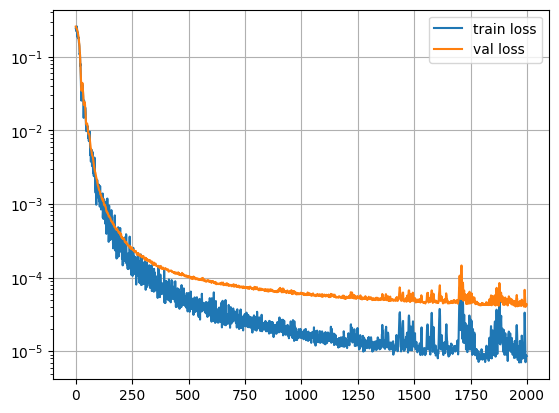

In [ ]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

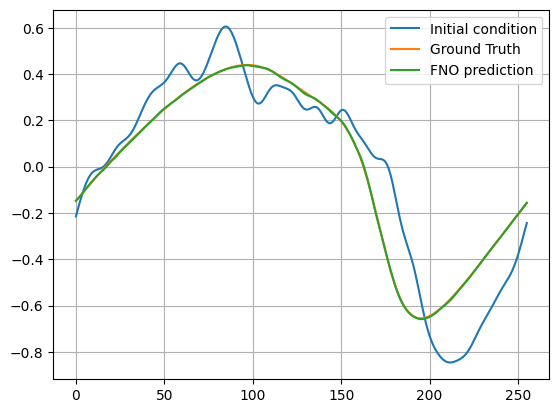

In [ ]:
plt.plot(test_x[1, 0, ::32], label="Initial condition")
plt.plot(test_y[1, 0, ::32], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::32])[0], label="FNO prediction")
plt.legend()
plt.grid()

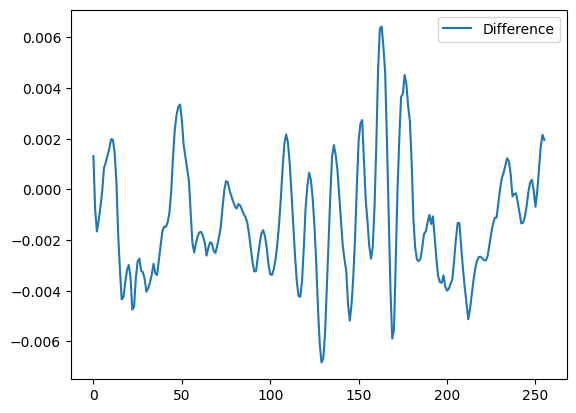

In [ ]:
plt.plot(fno(test_x[1, :, ::32])[0] - test_y[1, 0, ::32], label="Difference")
plt.legend()

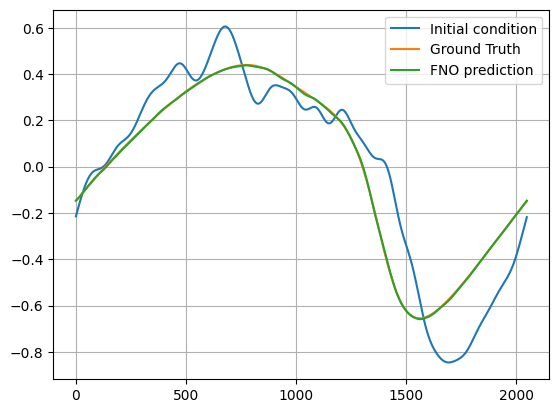

In [ ]:
# Zero-Shot superresolution
plt.plot(test_x[1, 0, ::4], label="Initial condition")
plt.plot(test_y[1, 0, ::4], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::4])[0], label="FNO prediction")
plt.legend()
plt.grid()


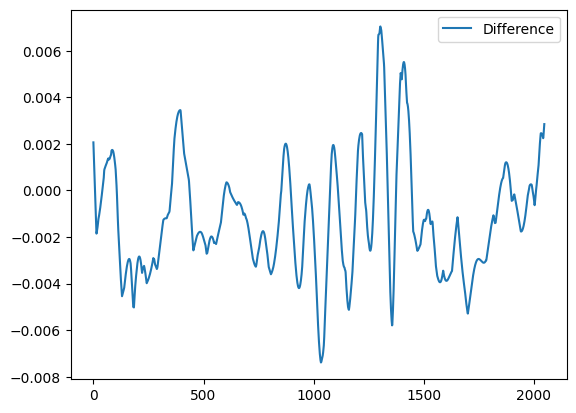

In [ ]:
plt.plot(fno(test_x[1, :, ::4])[0] - test_y[1, 0, ::4], label="Difference")
plt.legend()

In [ ]:
# Compute the error as reported in the FNO paper
test_pred = jax.vmap(fno)(test_x)

def relative_l2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

rel_l2_set = jax.vmap(relative_l2_norm)(test_pred, test_y)

In [ ]:
rel_l2_set.shape

(200,)

In [ ]:
jnp.mean(rel_l2_set) # ~1e-2

Array(0.00950637, dtype=float32)